# Kaggle Top Video Games 1995-2021 Notebook

## The aim of the assignment is to find user_reviews using the given dataset.

### First, we import our necessary libraries.

In [1]:
import pandas as pd
from sqlite3 import connect
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import batch_normalization
import tensorflow
from tensorflow_addons.metrics import RSquare
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.backend import clear_session


### We will use CountVectorizer from sklearn for our summary and reviews(Scraping code is also in the project) data. Below function allows us to choose only the words we want in the dataset.

In [2]:
def word_seperator(data, vectorizer, word_list):
    temp_list = [vectorizer.vocabulary_[word] for word in word_list.values]
    return data[:, temp_list]

### Dataset was transformed into sqlite dataset. We need to import them and remove the rows that are unknown.

In [3]:
conn = connect("data/dataset_review.db")
dataset = pd.read_sql("SELECT * FROM games", conn)
conn.close()

dataset.set_index("index", inplace=True)
dataset = dataset.loc[dataset["summary"].notnull()]
dataset = dataset.loc[dataset["reviews"].notnull()]
dataset = dataset[dataset["user_review"] != -1]
dataset.reset_index(drop=True, inplace=True)

### Now, we will use CountVectorizer to make a dataframe out of summary. Then, we use GLOVE word matrix so that our model can also understand some relations between words. After that we use KMeans algorithm that will categorize the summaries by their similarities. With this method, we aim to differ games by their categories.
### Note that this is a long process so that we also save the labels of KMeans. 

In [4]:
# tfv = CountVectorizer(analyzer='word',stop_words = 'english', lowercase=True)
# tfv.fit(dataset["summary"])
# summary = tfv.transform(dataset["summary"]).toarray()

# glove = pd.read_csv('data/glove.840B.300d.txt', sep=" ", header=None)
# glove.set_index(0, inplace=True)
# glove = glove.filter(items=tfv.get_feature_names_out(), axis=0)
# summary = word_seperator(data=summary, vectorizer=tfv, word_list=glove.index)


# kmeans = KMeans(n_clusters=30, random_state=7).fit(pd.DataFrame(summary.dot(glove)))
# del glove

# summary_kmeans = np.array(kmeans.labels_)
# del kmeans
# np.save("data/summary_kmeans.npy", summary_kmeans)

summary_kmeans = np.load("data/summary_kmeans.npy", allow_pickle=True)

### We need to implement CountVectorizer and GLOVE process to reviews as well. 

In [5]:
# count_vec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}', stop_words = 'english')
# word_vecs = count_vec.fit_transform(dataset["reviews"].values).toarray()
# glove = pd.read_csv('data/glove.840B.300d.txt', sep=" ", header=None)
# glove.set_index(0, inplace=True)
# glove = glove.filter(items=count_vec.get_feature_names_out(), axis=0)
# word_vecs = word_seperator(data=word_vecs, vectorizer=count_vec, word_list=glove.index)

# reviews = word_vecs.dot(glove)
# np.save("data/reviews_glove.npy", reviews)

reviews = np.load("data/reviews_glove.npy", allow_pickle=True)

### Now, it's time to seperate the dataset as features and labels.

In [6]:
categorical_labels = to_categorical(summary_kmeans, num_classes=30)
dataset = pd.concat([dataset, pd.DataFrame(categorical_labels, columns=["summary_kmean_" + str(i) for i in range(30)])], axis=1)
y = dataset["user_review"]
x = dataset.drop(columns=["user_review"])

### We also need to add reviews and summary results to the dataset. After, a standardization process is implemented. Te reason is that, we want to reduce the number of dimensions of features. Before using SVD for that reason, we need to standardize the dataset.

In [7]:
x.drop(columns=["name", "summary", "reviews"], inplace=True)

x = pd.concat([x, pd.DataFrame(reviews), pd.get_dummies(x.platform, prefix='plat')], axis=1)
x.drop(columns=["platform", "publish_year", "publish_month"], inplace=True)

x = StandardScaler().fit_transform(x)

svd = decomposition.TruncatedSVD(n_components=200, n_iter=7, random_state=7)
x = svd.fit_transform(x)

E:\Python39\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
E:\Python39\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### We also need to seperate dataset into training and test dataset for evaluation of the model.

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=7, test_size=0.2, shuffle=True)

### Our model is an Deep Neural Network with RELU activation function for first three layers and sigmoid for the final layer. Even though this is a regression problem, our output is between 0 and 1 which makes sigmoid as an acceptable activation function. We also need to add Dropout layers for avoiding the overfitting problem.

In [9]:
model = Sequential()

model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(batch_normalization.BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(batch_normalization.BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(batch_normalization.BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(batch_normalization.BatchNormalization())


model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="mean_squared_logarithmic_error", optimizer=tensorflow.keras.optimizers.Adam(), metrics=[tensorflow.keras.metrics.RootMeanSquaredError(), RSquare(dtype=tensorflow.float32, y_shape=(1,))])

### The model will be trained for 20 epochs with adam optimizer using 64 mini batch size. 

In [10]:
model_history = model.fit(x_train, y=y_train, batch_size=64, 
          epochs=20, verbose=1, 
          validation_data=(x_valid, y_valid))

Epoch 1/20
186/186 [==============================] - 2s 5ms/step - loss: 0.0169 - root_mean_squared_error: 0.2056 - r_square: -1.5038 - val_loss: 0.0073 - val_root_mean_squared_error: 0.1395 - val_r_square: -0.1438
Epoch 2/20
186/186 [==============================] - 1s 4ms/step - loss: 0.0082 - root_mean_squared_error: 0.1488 - r_square: -0.3105 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1270 - val_r_square: 0.0524
Epoch 3/20
186/186 [==============================] - 1s 4ms/step - loss: 0.0067 - root_mean_squared_error: 0.1333 - r_square: -0.0518 - val_loss: 0.0049 - val_root_mean_squared_error: 0.1111 - val_r_square: 0.2751
Epoch 4/20
186/186 [==============================] - 1s 4ms/step - loss: 0.0059 - root_mean_squared_error: 0.1241 - r_square: 0.0885 - val_loss: 0.0050 - val_root_mean_squared_error: 0.1145 - val_r_square: 0.2300
Epoch 5/20
186/186 [==============================] - 1s 4ms/step - loss: 0.0053 - root_mean_squared_error: 0.1183 - r_square: 0.1713 - val_

### Results are not very promising. However, we can see that the model learns since both validation and training errors decrease gradually. We can also see the effects of learning in the rsquare value as well. Let's also visualize the training and validation rsquare to see at which epoch model reachs its limit.

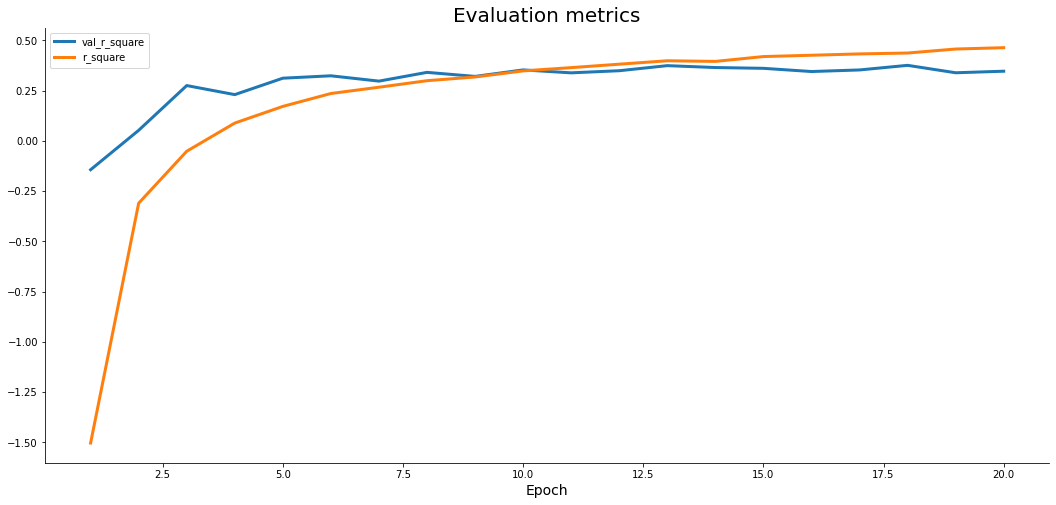

In [11]:
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 

plt.plot(
    np.arange(1, 21), 
    model_history.history['val_r_square'], 
    label='val_r_square', lw=3
)
plt.plot(
    np.arange(1, 21), 
    model_history.history['r_square'], 
    label='r_square', lw=3
)

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

### We observe that both rsquare values increases at the first. However, after some time, validation rsquare value begins to decrease due to overfitting. We may choose epoch number to use near the intersection of these two lines. Now, Let's see some of our predictions and true labels for comparison.

In [12]:
tuple(zip(model.predict(x_valid), y_valid))

((array([0.7792056], dtype=float32), 0.82),
 (array([0.738089], dtype=float32), 0.8),
 (array([0.7443561], dtype=float32), 0.74),
 (array([0.5324993], dtype=float32), 0.7),
 (array([0.79324263], dtype=float32), 0.85),
 (array([0.72220856], dtype=float32), 0.78),
 (array([0.69574344], dtype=float32), 0.75),
 (array([0.7521076], dtype=float32), 0.7),
 (array([0.7753979], dtype=float32), 0.8099999999999999),
 (array([0.6695219], dtype=float32), 0.6599999999999999),
 (array([0.64396423], dtype=float32), 0.64),
 (array([0.48952657], dtype=float32), 0.62),
 (array([0.71692705], dtype=float32), 0.6900000000000001),
 (array([0.8155905], dtype=float32), 0.86),
 (array([0.7912888], dtype=float32), 0.75),
 (array([0.7778472], dtype=float32), 0.8),
 (array([0.81655335], dtype=float32), 0.89),
 (array([0.68312716], dtype=float32), 0.67),
 (array([0.6674977], dtype=float32), 0.7),
 (array([0.7845619], dtype=float32), 0.77),
 (array([0.7126049], dtype=float32), 0.41),
 (array([0.78472155], dtype=floa